<a href="https://colab.research.google.com/github/Kirk-KD/asd-eye-tracking/blob/master/asd_eye_tracking.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import os
from collections import defaultdict

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import pointbiserialr

from sklearn import metrics, svm
from sklearn.ensemble import AdaBoostClassifier, RandomForestClassifier
from sklearn.model_selection import GroupKFold, train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.utils.class_weight import compute_sample_weight
from sklearn.preprocessing import StandardScaler

import xgboost as xgb

In [2]:
DATA_ROOT = '/content/drive/MyDrive/Colab Notebooks/ASD Eye Tracking/data'
METADATA_CSV = os.path.join(DATA_ROOT, 'Metadata_Participants.csv')
EYE_TRACKING_OUTPUT_DIR = os.path.join(DATA_ROOT, 'Eye-tracking Output')

# Load metadata

In [3]:
metadata_df = pd.read_csv(METADATA_CSV)
metadata_df = metadata_df.rename(columns={'ParticipantID': 'participant'})
metadata_df['Class'] = metadata_df['Class'].map({'ASD': 1, 'TD': 0})
metadata_df.head()

,participant,Gender,Age,Class,CARS Score
0,1,M,7.0,1,32.5
1,2,F,8.9,1,36.5
2,3,M,4.4,1,27.0
3,4,M,6.9,1,35.0
4,5,M,8.9,1,31.0


# Load and join experiments

In [4]:
columns_to_load = [
    'RecordingTime [ms]',  # timestamp
    'Trial',
    'Stimulus',
    'Participant',  # ID
    'Category Group',  # 'Eye' or 'Information'
    'Category Right',  # 'Fixation', 'Saccade', 'Blink', or 'Separator'
    'Category Left',
    'AOI Name Right',  # 'corps' (french for body) and others
    'AOI Name Left',
    'Pupil Diameter Right [mm]',
    'Pupil Diameter Left [mm]',
    'Point of Regard Right X [px]',
    'Point of Regard Right Y [px]',
    'Point of Regard Left X [px]',
    'Point of Regard Left Y [px]',
]

experiments = []
for i in range(1, 26):
    experiment = pd.read_csv(
        os.path.join(EYE_TRACKING_OUTPUT_DIR, f'{i}.csv'),
        dtype=defaultdict(lambda: str),
        na_values=['-'],
        index_col=0,
        low_memory=False
    )
    for col in columns_to_load:
        if col not in experiment.columns:
            experiment[col] = pd.NA
    experiment = experiment[columns_to_load]
    experiments.append(experiment)

experiments_df = pd.concat(experiments, ignore_index=True)

to_combine = {
    'look_category': ['Category Right', 'Category Left'],
    'pupil_diameter_mm': ['Pupil Diameter Right [mm]', 'Pupil Diameter Left [mm]'],
    'por_x': ['Point of Regard Right X [px]', 'Point of Regard Left X [px]'],
    'por_y': ['Point of Regard Right Y [px]', 'Point of Regard Left Y [px]']
}
for new_col, cols in to_combine.items():
    experiments_df[new_col] = experiments_df[cols[0]].combine_first(experiments_df[cols[1]])
    experiments_df.drop(columns=cols, inplace=True)

numerics = ['Participant', 'RecordingTime [ms]', 'pupil_diameter_mm', 'por_x', 'por_y']
for col in numerics:
    experiments_df[col] = pd.to_numeric(experiments_df[col], errors='coerce')

experiments_df.dropna(subset=['Participant', 'Stimulus', 'Trial'])
experiments_df.head()

,RecordingTime [ms],Trial,Stimulus,Participant,Category Group,AOI Name Right,AOI Name Left,look_category,pupil_diameter_mm,por_x,por_y
0,4780015.315,Trial020,20 eye tracking (ballon droite).avi,50.0,Information,NaN,NaN,Separator,NaN,NaN,NaN
1,4780020.865,Trial020,20 eye tracking (ballon droite).avi,50.0,Eye,corps,corps,Fixation,4.3785,595.6325,375.6149
2,4780040.758,Trial020,20 eye tracking (ballon droite).avi,50.0,Eye,corps,corps,Fixation,4.4050,597.3023,375.7919
3,4780080.503,Trial020,20 eye tracking (ballon droite).avi,50.0,Eye,corps,corps,Fixation,4.4273,596.9685,378.2868
4,4780120.360,Trial020,20 eye tracking (ballon droite).avi,50.0,Eye,corps,corps,Fixation,4.3514,596.4349,378.5467


What percent of each column is NA?

40% of participants are NA, this is because many rows have participants "Unidentified(Pos)" and "Unidentified(Neg)". The author of the dataset did not clarify the intended purpose and cause of these values, so for training, these rows will be dropped.

In [5]:
experiments_df.isna().mean().round(3)

,0
RecordingTime [ms],0.000
Trial,0.000
Stimulus,0.000
Participant,0.400
Category Group,0.000
AOI Name Right,0.682
AOI Name Left,0.684
look_category,0.048
pupil_diameter_mm,0.373
por_x,0.002


Validate POR coordinates

Invalid values at 0 and below, should be removed.

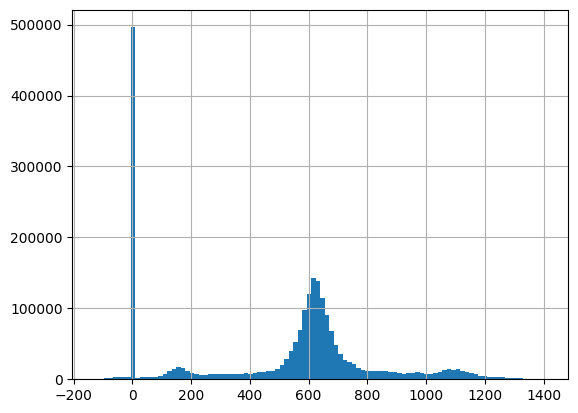

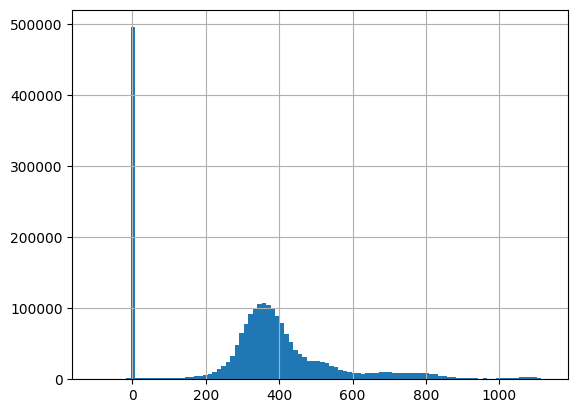

In [6]:
experiments_df['por_x'].hist(bins=100)
plt.show()
experiments_df['por_y'].hist(bins=100)
plt.show()

# Separate into groups

Group experiments by looking for the rows where 'Category Group' is 'Information'

In [7]:
experiments_df['Participant'] = experiments_df['Participant'].astype(int, errors='ignore')
experiments_df.dropna(subset=['Participant'], inplace=True)

experiments_df['SessionID'] = (experiments_df['Category Group'] == 'Information').cumsum()
grouped_experiments = experiments_df[experiments_df['Category Group'] == 'Eye'].groupby('SessionID')

Sample pupil diameters

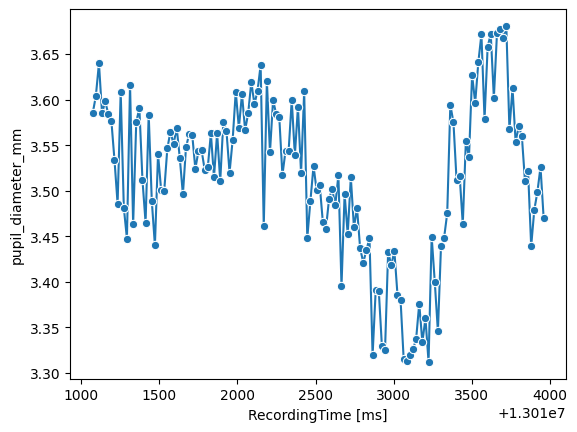

,RecordingTime [ms],Trial,Stimulus,Participant,Category Group,AOI Name Right,AOI Name Left,look_category,pupil_diameter_mm,por_x,por_y,SessionID
1766874,13011074.89,Trial005,NoImage,47.0,Eye,White Space,White Space,Fixation,3.5851,586.2463,305.8795,2699
1766875,13011094.77,Trial005,NoImage,47.0,Eye,White Space,White Space,Fixation,3.6037,585.1157,305.7483,2699
1766876,13011114.78,Trial005,NoImage,47.0,Eye,White Space,White Space,Fixation,3.6399,584.0753,304.8645,2699
1766877,13011134.66,Trial005,NoImage,47.0,Eye,White Space,White Space,Fixation,3.5848,584.3488,304.4997,2699
1766878,13011154.52,Trial005,NoImage,47.0,Eye,White Space,White Space,Fixation,3.5982,584.4099,301.9890,2699


In [8]:
import random

keys = list(grouped_experiments.groups.keys())
key = random.choice(keys)
sample = grouped_experiments.get_group(key)

sns.lineplot(
    data=sample,
    x='RecordingTime [ms]',
    y='pupil_diameter_mm',
    marker='o'
)
plt.show()

sample.head()

Verify the ~20ms interval of RecordingTime.

In [9]:
intervals = grouped_experiments['RecordingTime [ms]'].diff().dropna().reset_index()
intervals['RecordingTime [ms]'].median()

19.86700000008568

# Construct aggregated dataset

In [22]:
def make_event_mean_frequency(experiment, event_series):
    mean = event_series['event_duration_ms'].mean()
    freq = len(event_series) / len(experiment) / 0.02
    return mean, freq

def make_pupil_mean_range_speed(pupil_diameter_series):
    pupil_diameter_series = pupil_diameter_series.copy()

    ## Too extreme values
    pupil_diameter_series.loc[(pupil_diameter_series < 2) | (pupil_diameter_series > 8)] = pd.NA

    ## Flat areas in pupil diameter graph signals faulty data
    flat_mask = pupil_diameter_series.diff().abs() < 0.01
    consec_flat = (flat_mask != flat_mask.shift()).cumsum()
    flat_len = flat_mask.groupby(consec_flat).transform('sum')
    pupil_diameter_series.loc[flat_mask & (flat_len > 3)] = pd.NA

    ## Too many NaNs (>=20%)
    pupil_pct_na = pupil_diameter_series.isna().mean()

    if pupil_pct_na < 0.2:
        diameter_mean = pupil_diameter_series.mean()
        diameter_range = pupil_diameter_series.max() - pupil_diameter_series.min()

        diff = pupil_diameter_series.diff()
        speed = diff / 0.02
        speed_mean = speed.mean()
        return diameter_mean, diameter_range, speed_mean
    else:
        return pd.NA, pd.NA, pd.NA

# def make_pog_velocity_mean_range(pog_x, pog_y):
#     pog_x = pog_x.copy()
#     pog_y = pog_y.copy()

#     # Invalid coordinates
#     pog_x.loc[pog_x <= 0] = pd.NA
#     pog_y.loc[pog_y <= 0] = pd.NA

#     pct_na = max(pog_x.isna().mean(), pog_y.isna().mean())
#     if pct_na < 0.2:
#         pog_x = pog_x.interpolate(method='linear').ffill().bfill()
#         pog_y = pog_y.interpolate(method='linear').ffill().bfill()

#         dx = pog_x.diff()
#         dy = pog_y.diff()
#         vel = ((dx**2 + dy**2) ** 0.5) / 0.02  # pixels per second
#         return vel.mean(), vel.max() - vel.min()
#     else:
#         return pd.NA, pd.NA

def summarize_group(g):
    df = g.copy()

    df = df[~(df['Category Group'] == 'Information')]
    df['event'] = df['look_category']
    df['is_new_event'] = (df['event'] != df['event'].shift()).astype(int)
    df['event_id'] = df['is_new_event'].cumsum()
    events = (
        df.groupby(['event_id', 'event'])
        .size()
        .reset_index(name='n_rows')
    )
    events['event_duration_ms'] = events['n_rows'] * 20

    row = pd.Series({
        'participant': int(df['Participant'].unique()[0]),
        'stimulus': df['Stimulus'].unique()[0],
        'trial': df['Trial'].unique()[0]
    })

    for label in ['Saccade', 'Fixation']:
        lowered_label = label.lower()

        # Event duration mean and frequency (Hz)
        eye_events = events[events['event'] == label]
        duration_mean, duration_freq_hz = make_event_mean_frequency(df, eye_events)
        row[f'{lowered_label}_event_duration_mean'] = duration_mean
        row[f'{lowered_label}_event_freq'] = duration_freq_hz

        # Pupil diameter mean, range (mm)
        pupil_diameter = df.loc[df['event'] == label, 'pupil_diameter_mm']
        diameter_mean, diameter_range, diameter_speed = make_pupil_mean_range_speed(pupil_diameter)
        row[f'{lowered_label}_pupil_diameter_mean'] = diameter_mean
        row[f'{lowered_label}_pupil_diameter_range'] = diameter_range
        row[f'{lowered_label}_pupil_diameter_speed'] = diameter_speed

        # Point of regard velocity mean, range (px/s)
        # pog_x = df.loc[df['event'] == label, 'por_x']
        # pog_y = df.loc[df['event'] == label, 'por_y']
        # pog_vel_mean, pog_vel_range = make_pog_velocity_mean_range(pog_x, pog_y)
        # row[f'{lowered_label}_pog_vel_mean'] = pog_vel_mean
        # row[f'{lowered_label}_pog_vel_range'] = pog_vel_range

    return row

# initial construction
dataset = (
    grouped_experiments
    .apply(summarize_group)
    .dropna()
    .reset_index(drop=True)
    .merge(metadata_df, on='participant', how='left')
)

FEATURES = [
    'saccade_event_duration_mean',
    'saccade_event_freq',
    'fixation_event_duration_mean',
    'fixation_event_freq',
    'saccade_pupil_diameter_mean',
    'saccade_pupil_diameter_range',
    'fixation_pupil_diameter_mean',
    'fixation_pupil_diameter_range',
    # 'saccade_pog_vel_mean',
    # 'saccade_pog_vel_range',
    # 'fixation_pog_vel_mean',
    # 'fixation_pog_vel_range',
    'saccade_pupil_diameter_speed',
    # 'fixation_pupil_diameter_speed'
]
dataset[FEATURES] = dataset[FEATURES].apply(pd.to_numeric, errors='raise')
# apply z-score for features for each group of stimulus to normalize
# dataset[FEATURES] = dataset.groupby('stimulus')[FEATURES].transform(lambda x: (x - x.mean()) / x.std()).fillna(0)

dataset.head()


/tmp/ipython-input-3961617371.py:100: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(summarize_group)


,participant,stimulus,trial,saccade_event_duration_mean,saccade_event_freq,saccade_pupil_diameter_mean,saccade_pupil_diameter_range,saccade_pupil_diameter_speed,fixation_event_duration_mean,fixation_event_freq,fixation_pupil_diameter_mean,fixation_pupil_diameter_range,fixation_pupil_diameter_speed,Gender,Age,Class,CARS Score
0,50,20 eye tracking (ballon droite).avi,Trial020,106.714286,3.303445,3.664562,2.6397,-0.015405,194.388489,3.279849,3.661960,1.9357,-0.021115,F,11.5,0,NaN
1,52,20 eye tracking (ballon droite).avi,Trial020,132.571429,2.959831,2.601282,1.2680,0.011208,200.863309,2.938689,2.606727,1.1552,-0.004173,M,10.7,0,NaN
2,49,20 eye tracking (ballon droite).avi,Trial020,86.229508,3.218997,3.611557,1.6706,0.006629,189.206349,3.324538,3.624559,1.1389,-0.001884,F,12.3,0,NaN
3,55,20 eye tracking (ballon droite).avi,Trial020,99.310345,2.055280,3.295281,1.4416,-0.011232,190.666667,2.657690,3.311302,1.6131,-0.040847,F,6.5,0,NaN
4,53,20 eye tracking (ballon droite).avi,Trial020,110.517241,2.632773,2.682989,1.5268,-0.014938,271.478261,2.610077,2.748847,0.9393,-0.011814,M,6.8,0,NaN


Class distribution (0 = TD, 1 = ASD)

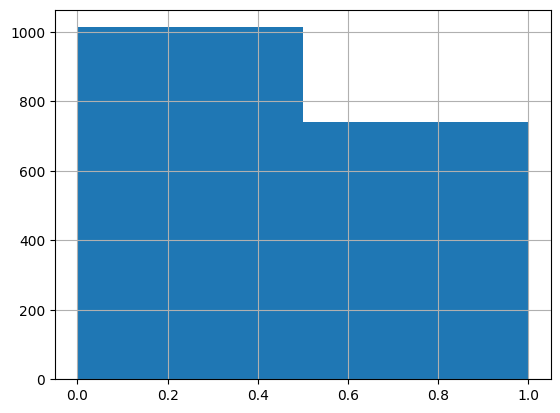

In [11]:
dataset['Class'].hist(bins=2)
plt.show()

# Train

In [15]:
SEED = 7

class Trainer:
    def __init__(self, X, y, groups, model_class, balanced=False, n_splits=5):
        self.X = X.copy()
        self.y = y.copy()
        self.groups = groups
        self.model_class = model_class
        self.balanced = balanced
        self.n_splits = n_splits
        self.model = None

    def fit(self):
        gkf = GroupKFold(n_splits=self.n_splits, shuffle=True, random_state=SEED)
        results_list = []
        all_y_true, all_y_pred = [], []
        i = 0

        for train_idx, test_idx in gkf.split(self.X, self.y, groups=self.groups):
            i += 1;
            print(f'FIT {self.model_class.__name__}, balanced={self.balanced}, group k-fold split {i} of {self.n_splits}')

            X_train, X_test = self.X.iloc[train_idx].copy(), self.X.iloc[test_idx].copy()
            y_train, y_test = self.y.iloc[train_idx], self.y.iloc[test_idx]

            stim_stats = X_train.groupby('stimulus')[FEATURES].agg(['mean','std'])

            # Apply z-score per stimulus for training set
            def zscore_train(row):
                mean = stim_stats.loc[row['stimulus'], (slice(None), 'mean')]
                std = stim_stats.loc[row['stimulus'], (slice(None), 'std')]
                return (row[FEATURES] - mean.values) / std.values

            X_train[FEATURES] = X_train.apply(zscore_train, axis=1).fillna(0)

            # Apply same training stats to test set. Do this to simulate real use case.
            # In real use case: user is expected to have existing baseline data
            # to normalize client data with due to different possible stimuli.
            def zscore_test(row):
                if row['stimulus'] in stim_stats.index:
                    mean = stim_stats.loc[row['stimulus'], (slice(None), 'mean')]
                    std = stim_stats.loc[row['stimulus'], (slice(None), 'std')]
                    return (row[FEATURES] - mean.values) / std.values
                else:
                    # Stimulus unseen in training
                    return row[FEATURES] * 0
            X_test[FEATURES] = X_test.apply(zscore_test, axis=1).fillna(0)

            # Drop 'stimulus'
            X_train.drop(columns=['stimulus'], inplace=True)
            X_test.drop(columns=['stimulus'], inplace=True)

            model_kwargs = {'random_state': SEED} if 'random_state' in self.model_class().get_params() else {}
            if self.balanced and hasattr(self.model_class, 'class_weight'):
                model_kwargs['class_weight'] = 'balanced'

            self.model = self.model_class(**model_kwargs)

            if self.balanced and hasattr(self.model, 'fit'):
                sample_weights = compute_sample_weight(class_weight='balanced', y=y_train)
                self.model.fit(X_train, y_train, sample_weight=sample_weights)
            else:
                self.model.fit(X_train, y_train)

            y_pred = self.model.predict(X_test)
            all_y_true.extend(y_test)
            all_y_pred.extend(y_pred)

            if hasattr(self.model, "predict_proba"):
                y_prob = self.model.predict_proba(X_test)[:, 1]
                roc_auc = metrics.roc_auc_score(y_test, y_prob)
            else:
                y_score = self.model.decision_function(X_test)
                roc_auc = metrics.roc_auc_score(y_test, y_score)

            results = {
                'balanced_accuracy': metrics.balanced_accuracy_score(y_test, y_pred),
                'kappa': metrics.cohen_kappa_score(y_test, y_pred),
                'precision': metrics.precision_score(y_test, y_pred),
                'sensitivity': metrics.recall_score(y_test, y_pred),
                'specificity': metrics.recall_score(y_test, y_pred, pos_label=0),
                'f1': metrics.f1_score(y_test, y_pred),
                'roc_auc': roc_auc
            }
            results_list.append(results)

        avg_results = {k: np.mean([r[k] for r in results_list]) for k in results_list[0]}
        cm = metrics.confusion_matrix(all_y_true, all_y_pred)
        cm_df = pd.DataFrame(cm, index=['TD', 'ASD'], columns=['TD', 'ASD'])
        return avg_results, cm_df


In [16]:
model_configs = [
    ('DecisionTree', DecisionTreeClassifier, False),
    ('DecisionTree_Balanced', DecisionTreeClassifier, True),
    ('SVM', svm.SVC, False),
    ('SVM_Balanced', svm.SVC, True),
    ('KNN', KNeighborsClassifier, False),
    ('XGBoost', xgb.XGBClassifier, False),
    ('XGBoost_Balanced', xgb.XGBClassifier, True),
    ('AdaBoost', AdaBoostClassifier, False),
    ('AdaBoost_Balanced', AdaBoostClassifier, True)
]

results_list = []
confusion_matrices = {}

for name, model_class, balanced in model_configs:
    trainer = Trainer(
        X=dataset[FEATURES + ['stimulus']],
        y=dataset['Class'],
        groups=dataset['participant'],
        model_class=model_class,
        balanced=balanced
    )
    metrics_results, cm = trainer.fit()
    results_list.append({'Name': name, **metrics_results})
    confusion_matrices[name] = cm

df_cv_results = pd.DataFrame(results_list)
df_cv_results = df_cv_results.sort_values('kappa', ascending=False)
df_cv_results


FIT DecisionTreeClassifier, balanced=False, group k-fold split 1 of 5
FIT DecisionTreeClassifier, balanced=False, group k-fold split 2 of 5
FIT DecisionTreeClassifier, balanced=False, group k-fold split 3 of 5
FIT DecisionTreeClassifier, balanced=False, group k-fold split 4 of 5
FIT DecisionTreeClassifier, balanced=False, group k-fold split 5 of 5
FIT DecisionTreeClassifier, balanced=True, group k-fold split 1 of 5
FIT DecisionTreeClassifier, balanced=True, group k-fold split 2 of 5
FIT DecisionTreeClassifier, balanced=True, group k-fold split 3 of 5
FIT DecisionTreeClassifier, balanced=True, group k-fold split 4 of 5
FIT DecisionTreeClassifier, balanced=True, group k-fold split 5 of 5
FIT SVC, balanced=False, group k-fold split 1 of 5
FIT SVC, balanced=False, group k-fold split 2 of 5
FIT SVC, balanced=False, group k-fold split 3 of 5
FIT SVC, balanced=False, group k-fold split 4 of 5
FIT SVC, balanced=False, group k-fold split 5 of 5
FIT SVC, balanced=True, group k-fold split 1 of 5


,Name,balanced_accuracy,kappa,precision,sensitivity,specificity,f1,roc_auc
2,SVM,0.751498,0.483942,0.710833,0.714184,0.788812,0.706402,0.799917
3,SVM_Balanced,0.735478,0.450324,0.666493,0.768592,0.702364,0.709652,0.796225
5,XGBoost,0.726181,0.439542,0.685629,0.680533,0.771829,0.677940,0.778063
4,KNN,0.718605,0.430029,0.687555,0.648312,0.788898,0.662790,0.763244
6,XGBoost_Balanced,0.712139,0.413137,0.662511,0.688641,0.735638,0.672578,0.774158
7,AdaBoost,0.704811,0.388070,0.661623,0.654901,0.754721,0.649861,0.770121
8,AdaBoost_Balanced,0.701140,0.376830,0.620126,0.732517,0.669763,0.666972,0.767711
0,DecisionTree,0.657250,0.301276,0.596017,0.612583,0.701917,0.595173,0.653543
1,DecisionTree_Balanced,0.637634,0.262675,0.579464,0.583932,0.691335,0.572056,0.642562


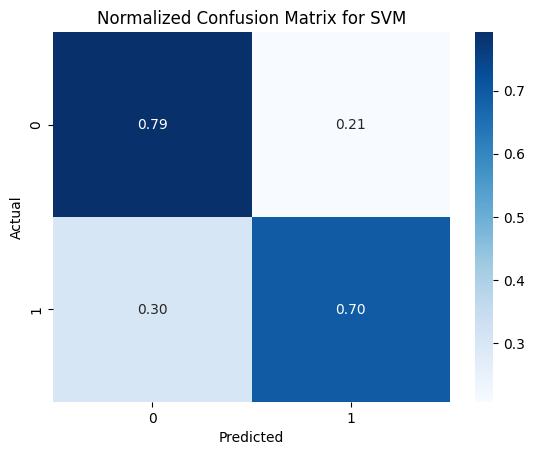

In [17]:
def show_cm(model_name):
    cm = confusion_matrices[model_name]
    cm_normalized = cm.div(cm.sum(axis=1), axis=0)

    sns.heatmap(cm_normalized, annot=True, fmt='.2f', cmap='Blues', xticklabels=[0,1], yticklabels=[0,1])
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title(f'Normalized Confusion Matrix for {model_name}')
    plt.show()

show_cm('SVM')